# [CoE202] note 09. Generative Adversarial Network (MNIST generation)

- Class Date : 21.05.27.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

1. As usual let's start with importing the libraries that we want to use.

In [ ]:
import matplotlib.pyplot as plt # this is for importing matplotlib.pyplot (library for graph plot)
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

2. Let's define a function for data visualization.




In [ ]:
# define a function to plot data
def show_data(data, label=[]):
    # data shape : torch.Size([Batch_size, 1, 28, 28])
    # label shape : torch.Size([4])
    num_row = 3
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)

    if len(label)==0:
        for i in range(12):
            ax = axes[i//num_col, i%num_col]
            ax.imshow(data[i, 0].cpu(), cmap='gray')
        plt.tight_layout()
        plt.show()
    else:
        for i in range(12):
            ax = axes[i//num_col, i%num_col]
            ax.imshow(data[i, 0].cpu(), cmap='gray')
            ax.set_title(f'label : {label[i].cpu().item()}')
        plt.tight_layout()
        plt.show()

3. Let's define a simple discrimator network (MLP).

In [ ]:
# Define MLP discriminator
class discriminator(nn.Module):

    # initialization
    def __init__(self):
        super(discriminator, self).__init__()
        self.layer1 = nn.Linear(28*28, 256)
        self.layer2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    
    # forward path
    def forward(self, x):
        # Make 2D image to 1D vector and we can use Linear layer (Fully-connected layer)
        x = x.view(-1, 1, 28*28)  # [Quiz
        # Used relu to add non-linearity
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sig(x)
        return x

4. Let's define a simple generator network (MLP).

In [ ]:
# Define MLP generator
class generator(nn.Module):

    # initialization
    def __init__(self, z_dimension=20):
        super(generator, self).__init__()
        self.layer1 = nn.Linear(z_dimension, 256)
        self.layer2 = nn.Linear(256, 28*28)
        self.relu = nn.ReLU()
    
    # forward path
    def forward(self, x):       
        # Used relu to add non-linearity
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = x.view(-1, 1, 28, 28)  
        return x

5. Let's use GPU acceleration.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

6. Let's download the MNIST dataset for training our GAN.

In [ ]:
# load MNIST data
batch_size = 64
mnist_dataset = torchvision.datasets.MNIST("../mnist_data/",
                                               download=True,
                                               transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                               ]))

train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw




Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


7. Let's take a look at the (real) MNIST dataset.

ground truth example


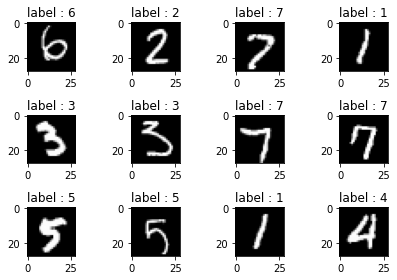

In [ ]:
# show ground truth classification (one batch)
one_batch_data, one_batch_label  = next(iter(train_loader))
print('ground truth example')
show_data(one_batch_data, one_batch_label)

8. Here's are generator and discriminator. Let's put them on GPU.

In [ ]:
# my generator & discriminator
G = generator().to(device)  # generator instance
D = discriminator().to(device)  # discriminator instance

9. Let's test our untrained generator with a random input. For that we are going to define a function for random input generation.

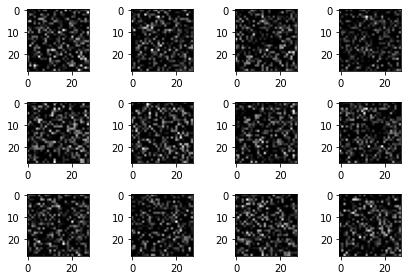

In [ ]:
# generate a random input for the generator
def sample_z(batch_size = 1, z_dimension=20):
    return torch.randn(batch_size, z_dimension, device=device)
    
# generate noise (seed)
z_dimension = 20 # dimension of the random input vector
z = sample_z(16, z_dimension)

# generate image from the seed (with untrained network)
img_fake = G(z)

# show generated images (with untrained network)
show_data(img_fake.detach())

In [ ]:
def evaluate_model(G, D):
    
    p_real, p_fake = 0.,0.
    count_real, count_fake = 0., 0.

    G.eval()
    D.eval()
        
    for img_batch, label_batch in valid_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)     
        with torch.autograd.no_grad():
            p_real += torch.sum(torch.round(D(img_batch)))
            p_fake += torch.sum(torch.round(D(G(sample_z(batch_size)))))

        count_real += img_batch.shape[0]
        count_fake += batch_size
                    
    return p_real/count_real, p_fake/count_fake 

11. There are two separate loss functions for training the discriminator and the generator, respectively.

$$
\mathcal{L}_{D} = -  
( log (D(x)) + log(1-D(G(z))))
$$

$$
\mathcal{L}_{G} = -log(D(G(z))
$$


(epoch 1/100) p_real: 0.961800, p_fake: 0.000597, loss_D: 0.771868,  loss_G: 1.441073
(epoch 2/100) p_real: 0.886200, p_fake: 0.018511, loss_D: 0.684740,  loss_G: 1.257006
(epoch 3/100) p_real: 0.774100, p_fake: 0.086584, loss_D: 0.636998,  loss_G: 1.577197
(epoch 4/100) p_real: 0.820700, p_fake: 0.061405, loss_D: 0.565819,  loss_G: 1.764120
(epoch 5/100) p_real: 0.806900, p_fake: 0.132365, loss_D: 0.620949,  loss_G: 1.682385
(epoch 6/100) p_real: 0.877000, p_fake: 0.033340, loss_D: 0.640241,  loss_G: 1.658058
(epoch 7/100) p_real: 0.834700, p_fake: 0.072054, loss_D: 0.669417,  loss_G: 1.621739
(epoch 8/100) p_real: 0.787800, p_fake: 0.093153, loss_D: 0.668148,  loss_G: 1.779841
(epoch 9/100) p_real: 0.858000, p_fake: 0.115048, loss_D: 0.758998,  loss_G: 1.535196
(epoch 10/100) p_real: 0.848000, p_fake: 0.069765, loss_D: 0.701455,  loss_G: 1.635596


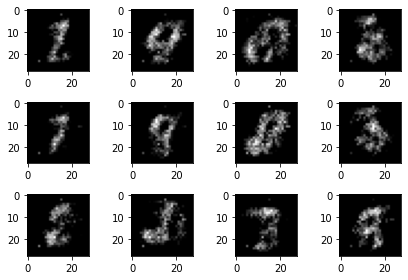

(epoch 11/100) p_real: 0.800800, p_fake: 0.064988, loss_D: 0.782701,  loss_G: 1.582285
(epoch 12/100) p_real: 0.816100, p_fake: 0.071158, loss_D: 0.755879,  loss_G: 1.601596
(epoch 13/100) p_real: 0.756500, p_fake: 0.135947, loss_D: 0.814261,  loss_G: 1.548064
(epoch 14/100) p_real: 0.781300, p_fake: 0.133857, loss_D: 0.840416,  loss_G: 1.475283
(epoch 15/100) p_real: 0.741300, p_fake: 0.145900, loss_D: 0.851083,  loss_G: 1.514321
(epoch 16/100) p_real: 0.734300, p_fake: 0.143810, loss_D: 0.891901,  loss_G: 1.461647
(epoch 17/100) p_real: 0.832800, p_fake: 0.157444, loss_D: 1.026279,  loss_G: 1.312465
(epoch 18/100) p_real: 0.820600, p_fake: 0.163416, loss_D: 0.867771,  loss_G: 1.382434
(epoch 19/100) p_real: 0.792000, p_fake: 0.098527, loss_D: 0.921108,  loss_G: 1.469630
(epoch 20/100) p_real: 0.780900, p_fake: 0.146596, loss_D: 0.917886,  loss_G: 1.452119


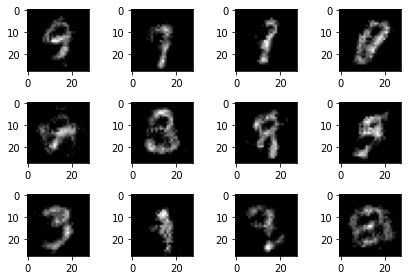

(epoch 21/100) p_real: 0.667400, p_fake: 0.185709, loss_D: 0.973020,  loss_G: 1.300424
(epoch 22/100) p_real: 0.777100, p_fake: 0.128483, loss_D: 0.916853,  loss_G: 1.518789
(epoch 23/100) p_real: 0.755100, p_fake: 0.188893, loss_D: 0.916395,  loss_G: 1.440741
(epoch 24/100) p_real: 0.750100, p_fake: 0.148587, loss_D: 0.947251,  loss_G: 1.349983
(epoch 25/100) p_real: 0.785300, p_fake: 0.186206, loss_D: 0.914225,  loss_G: 1.496791
(epoch 26/100) p_real: 0.754700, p_fake: 0.196855, loss_D: 0.913924,  loss_G: 1.466738
(epoch 27/100) p_real: 0.749900, p_fake: 0.212281, loss_D: 0.937117,  loss_G: 1.451243
(epoch 28/100) p_real: 0.798000, p_fake: 0.125697, loss_D: 0.950282,  loss_G: 1.462425
(epoch 29/100) p_real: 0.767100, p_fake: 0.184614, loss_D: 0.944007,  loss_G: 1.457342
(epoch 30/100) p_real: 0.704600, p_fake: 0.149184, loss_D: 0.955659,  loss_G: 1.446355


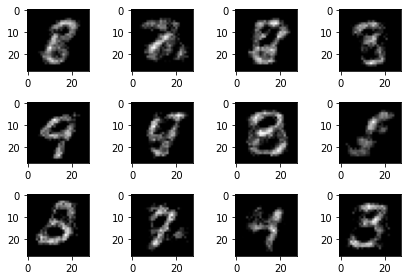

(epoch 31/100) p_real: 0.797500, p_fake: 0.207006, loss_D: 0.962786,  loss_G: 1.444243
(epoch 32/100) p_real: 0.747400, p_fake: 0.181330, loss_D: 0.975046,  loss_G: 1.444352
(epoch 33/100) p_real: 0.725300, p_fake: 0.187002, loss_D: 0.916475,  loss_G: 1.529669
(epoch 34/100) p_real: 0.747500, p_fake: 0.147492, loss_D: 1.087689,  loss_G: 1.318469
(epoch 35/100) p_real: 0.741800, p_fake: 0.181230, loss_D: 0.885244,  loss_G: 1.562695
(epoch 36/100) p_real: 0.681800, p_fake: 0.197651, loss_D: 0.933532,  loss_G: 1.491526
(epoch 37/100) p_real: 0.754000, p_fake: 0.177946, loss_D: 0.918878,  loss_G: 1.481749
(epoch 38/100) p_real: 0.739100, p_fake: 0.197154, loss_D: 0.926211,  loss_G: 1.472642
(epoch 39/100) p_real: 0.748500, p_fake: 0.172373, loss_D: 0.917952,  loss_G: 1.472137
(epoch 40/100) p_real: 0.725600, p_fake: 0.169387, loss_D: 0.927473,  loss_G: 1.477768


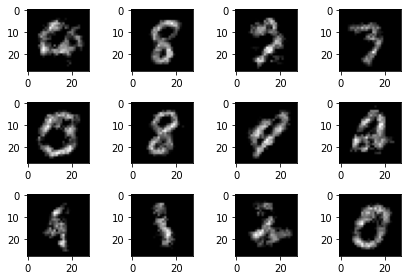

(epoch 41/100) p_real: 0.783700, p_fake: 0.183519, loss_D: 0.906723,  loss_G: 1.492208
(epoch 42/100) p_real: 0.768300, p_fake: 0.180434, loss_D: 0.891139,  loss_G: 1.536587
(epoch 43/100) p_real: 0.766500, p_fake: 0.158340, loss_D: 0.876031,  loss_G: 1.566321
(epoch 44/100) p_real: 0.769900, p_fake: 0.144904, loss_D: 0.882710,  loss_G: 1.582640
(epoch 45/100) p_real: 0.722800, p_fake: 0.146198, loss_D: 0.886486,  loss_G: 1.564817
(epoch 46/100) p_real: 0.791200, p_fake: 0.161525, loss_D: 0.874252,  loss_G: 1.554812
(epoch 47/100) p_real: 0.794100, p_fake: 0.174761, loss_D: 0.873075,  loss_G: 1.578619
(epoch 48/100) p_real: 0.776300, p_fake: 0.195561, loss_D: 0.861442,  loss_G: 1.601052
(epoch 49/100) p_real: 0.767900, p_fake: 0.160330, loss_D: 0.858287,  loss_G: 1.623752
(epoch 50/100) p_real: 0.393900, p_fake: 0.572154, loss_D: 0.937404,  loss_G: 1.567773


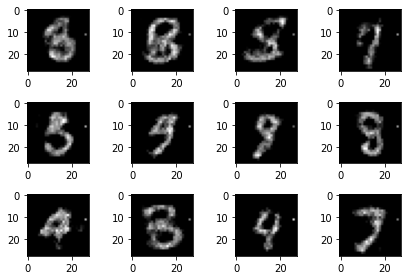

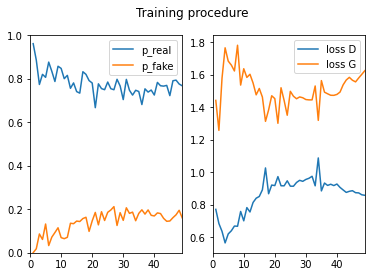

(epoch 51/100) p_real: 0.631000, p_fake: 0.238356, loss_D: 1.369896,  loss_G: 1.072446
(epoch 52/100) p_real: 0.660400, p_fake: 0.189092, loss_D: 1.118709,  loss_G: 1.194059
(epoch 53/100) p_real: 0.731800, p_fake: 0.145999, loss_D: 0.971567,  loss_G: 1.406154
(epoch 54/100) p_real: 0.717500, p_fake: 0.190386, loss_D: 0.894348,  loss_G: 1.535114
(epoch 55/100) p_real: 0.788600, p_fake: 0.164809, loss_D: 0.862831,  loss_G: 1.604890
(epoch 56/100) p_real: 0.795100, p_fake: 0.171178, loss_D: 0.849144,  loss_G: 1.636289
(epoch 57/100) p_real: 0.772200, p_fake: 0.167994, loss_D: 0.845361,  loss_G: 1.651244
(epoch 58/100) p_real: 0.775200, p_fake: 0.157345, loss_D: 0.830436,  loss_G: 1.649198
(epoch 59/100) p_real: 0.790600, p_fake: 0.166103, loss_D: 0.824481,  loss_G: 1.683351
(epoch 60/100) p_real: 0.724900, p_fake: 0.178742, loss_D: 0.938065,  loss_G: 1.524735


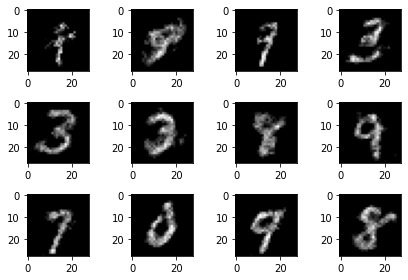

(epoch 61/100) p_real: 0.809700, p_fake: 0.202229, loss_D: 0.863051,  loss_G: 1.613547
(epoch 62/100) p_real: 0.786800, p_fake: 0.181827, loss_D: 0.817233,  loss_G: 1.719566
(epoch 63/100) p_real: 0.776000, p_fake: 0.118730, loss_D: 0.807154,  loss_G: 1.738208
(epoch 64/100) p_real: 0.771500, p_fake: 0.119128, loss_D: 0.799832,  loss_G: 1.730427
(epoch 65/100) p_real: 0.780300, p_fake: 0.173467, loss_D: 0.790011,  loss_G: 1.739096
(epoch 66/100) p_real: 0.774700, p_fake: 0.174761, loss_D: 0.786017,  loss_G: 1.759664
(epoch 67/100) p_real: 0.780600, p_fake: 0.136943, loss_D: 0.776424,  loss_G: 1.796174
(epoch 68/100) p_real: 0.756700, p_fake: 0.135649, loss_D: 0.781853,  loss_G: 1.776102
(epoch 69/100) p_real: 0.747900, p_fake: 0.130275, loss_D: 0.772644,  loss_G: 1.789216
(epoch 70/100) p_real: 0.883800, p_fake: 0.096338, loss_D: 0.895101,  loss_G: 1.701192


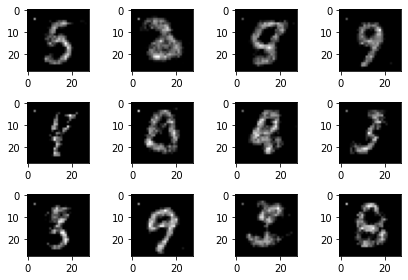

(epoch 71/100) p_real: 0.762700, p_fake: 0.144805, loss_D: 0.797890,  loss_G: 1.791043
(epoch 72/100) p_real: 0.774000, p_fake: 0.153264, loss_D: 0.769747,  loss_G: 1.836732
(epoch 73/100) p_real: 0.761600, p_fake: 0.123109, loss_D: 0.766712,  loss_G: 1.806651
(epoch 74/100) p_real: 0.790700, p_fake: 0.146895, loss_D: 0.757373,  loss_G: 1.799625
(epoch 75/100) p_real: 0.805900, p_fake: 0.154459, loss_D: 0.753636,  loss_G: 1.847549
(epoch 76/100) p_real: 0.741600, p_fake: 0.109574, loss_D: 0.745857,  loss_G: 1.860090
(epoch 77/100) p_real: 0.790600, p_fake: 0.133559, loss_D: 0.743707,  loss_G: 1.870586
(epoch 78/100) p_real: 0.752900, p_fake: 0.108778, loss_D: 0.737449,  loss_G: 1.881123
(epoch 79/100) p_real: 0.792100, p_fake: 0.129777, loss_D: 0.731131,  loss_G: 1.887614
(epoch 80/100) p_real: 0.785900, p_fake: 0.124005, loss_D: 0.724609,  loss_G: 1.906927


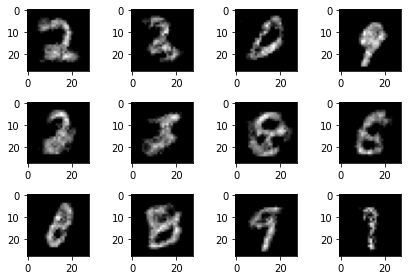

(epoch 81/100) p_real: 0.752500, p_fake: 0.114053, loss_D: 0.728953,  loss_G: 1.894966
(epoch 82/100) p_real: 0.773000, p_fake: 0.130573, loss_D: 0.727163,  loss_G: 1.911682
(epoch 83/100) p_real: 0.791400, p_fake: 0.134554, loss_D: 0.723109,  loss_G: 1.935027
(epoch 84/100) p_real: 0.799200, p_fake: 0.169586, loss_D: 0.713493,  loss_G: 1.937401
(epoch 85/100) p_real: 0.795300, p_fake: 0.120621, loss_D: 0.715802,  loss_G: 1.936146
(epoch 86/100) p_real: 0.763900, p_fake: 0.124303, loss_D: 0.712483,  loss_G: 1.953295
(epoch 87/100) p_real: 0.728300, p_fake: 0.098627, loss_D: 0.707930,  loss_G: 1.954742
(epoch 88/100) p_real: 0.782200, p_fake: 0.125697, loss_D: 0.709293,  loss_G: 1.960146
(epoch 89/100) p_real: 0.768900, p_fake: 0.132564, loss_D: 0.706287,  loss_G: 1.960466
(epoch 90/100) p_real: 0.786400, p_fake: 0.125398, loss_D: 0.700490,  loss_G: 1.974274


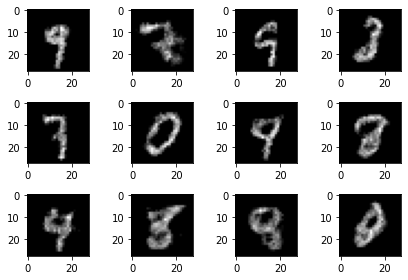

(epoch 91/100) p_real: 0.790300, p_fake: 0.138933, loss_D: 0.699598,  loss_G: 1.980434
(epoch 92/100) p_real: 0.780300, p_fake: 0.129379, loss_D: 0.694706,  loss_G: 1.996051
(epoch 93/100) p_real: 0.778400, p_fake: 0.133957, loss_D: 0.696377,  loss_G: 2.008016
(epoch 94/100) p_real: 0.787100, p_fake: 0.151772, loss_D: 0.688465,  loss_G: 2.014560
(epoch 95/100) p_real: 0.778400, p_fake: 0.111863, loss_D: 0.685430,  loss_G: 2.018629
(epoch 96/100) p_real: 0.775100, p_fake: 0.110370, loss_D: 0.683755,  loss_G: 2.012559
(epoch 97/100) p_real: 0.806100, p_fake: 0.141919, loss_D: 0.682072,  loss_G: 2.043616
(epoch 98/100) p_real: 0.780100, p_fake: 0.126493, loss_D: 0.680770,  loss_G: 2.037758
(epoch 99/100) p_real: 0.773500, p_fake: 0.113754, loss_D: 0.681588,  loss_G: 2.048471
(epoch 100/100) p_real: 0.780900, p_fake: 0.118033, loss_D: 0.671807,  loss_G: 2.058317


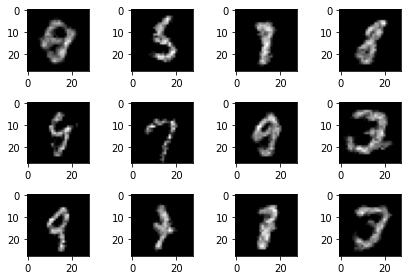

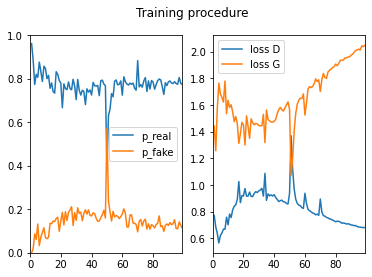

In [ ]:
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = torch.optim.Adam(D.parameters(), lr = 0.0002)
n_iter = 100

p_real_iter = np.zeros(n_iter, dtype=float)  # Temporary numpy array to save loss for each epoch
p_fake_iter = np.zeros(n_iter, dtype=float)
loss_g_iter = np.zeros(n_iter, dtype=float)
loss_d_iter = np.zeros(n_iter, dtype=float)

for epoch in range(n_iter):
    
    # run training
    G.train()
    D.train()
    total_loss_d, total_loss_g, total_count_d, total_count_g = 0.0, 0.0, 0.0,0.0
    for img_batch, label_batch in train_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        #################################################################################
        ### ACTIVITY  : fill in this part 
        ### update discriminator     

        # set gradient in optimizer_d to zero
        # calculate p_real = D(x) (x needs to be flattened)
        # calculate p_fake = D(G(z))
        # calculate loss for discriminator (hint: use the L_{D} equation above. use torch.ones_like )
        # additional hint 1 : cross_entropy(y, D(x)) = -(y*log(D(x))  + (1-y)*(log(1-D(x))) --> For real data, cross_entropy(1, D(x)) = -(log(D(x))
        # additional hint 2 : cross_entropy(y, D(G(z)) = -(y*log(D(G(z)))  + (1-y)*(log(1-D(G(z)))) --> For fake data, cross_entropy(0, D(G(z))) = -(log(1-D(G(z))))
        # in other words, we can use the relation above, to express L_{D} using built-in BCELoss function
        # additional hint 3: see generator  update part carefully
        # perform backprop
        # update optimizer_d

        #################################################################################


        ### update generator 
        optimizer_g.zero_grad()
        p_fake = D(G(sample_z(batch_size))) # D(G(z))
        loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)).mean()  
        ### instead of loss_g = criterion(1-p_fake, torch.zeros_like(p_fake).to(device)).mean()  
        loss_g.backward()
        optimizer_g.step()

        total_loss_d += loss_d.item()
        total_loss_g += loss_g.item()
        total_count_d += 1
        total_count_g += 1

    # check current performance
    p_real, p_fake = evaluate_model(G,D)    
    p_real_iter[epoch] = p_real
    p_fake_iter[epoch] = p_fake
    loss_d_iter[epoch] = total_loss_d/total_count_d
    loss_g_iter[epoch] = total_loss_g/total_count_g

    if((epoch+1)% 1 == 0):
        print('(epoch %i/%i) p_real: %f, p_fake: %f, loss_D: %f,  loss_G: %f' % (epoch+1, n_iter, p_real, p_fake, total_loss_d/total_count_d, total_loss_g/total_count_g))

    if((epoch+1)% 10 == 0):
        z = sample_z(16)
        img_fake = G(z)
        show_data(img_fake.detach())

    if((epoch+1)% 50 == 0):
        # show loss during training
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Training procedure')
        ax1.plot(range(1,epoch+1), p_real_iter[0:epoch],   label='p_real')
        ax1.plot(range(1,epoch+1), p_fake_iter[0:epoch],  label='p_fake')
        ax1.axis(xmin=0,xmax=epoch)
        ax1.axis(ymin=0,ymax=1)
        ax1.legend()
        ax2.plot(range(1,epoch+1), loss_d_iter[0:epoch],  label='loss D')
        ax2.plot(range(1,epoch+1), loss_g_iter[0:epoch],  label='loss G')
        ax2.axis(xmin=0,xmax=epoch)        
        ax2.legend()
        plt.show()

12. Let's check out the final results.

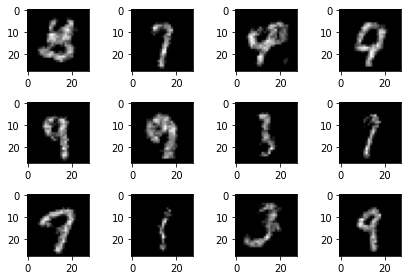

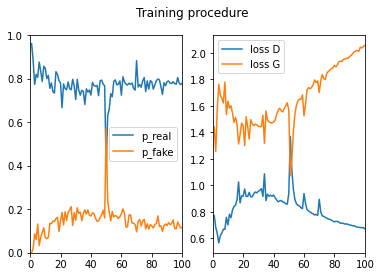

In [ ]:
# show results from trained generator
z = sample_z(16)
img_fake = G(z)
show_data(img_fake.detach())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training procedure')
ax1.plot(range(1,n_iter+1), p_real_iter[0:n_iter],   label='p_real')
ax1.plot(range(1,n_iter+1), p_fake_iter[0:n_iter],  label='p_fake')
ax1.axis(xmin=0,xmax=n_iter)
ax1.axis(ymin=0,ymax=1)
ax1.legend()
ax2.plot(range(1,n_iter+1), loss_d_iter[0:n_iter],  label='loss D')
ax2.plot(range(1,n_iter+1), loss_g_iter[0:n_iter],  label='loss G')
ax2.axis(xmin=0,xmax=n_iter)
ax2.legend()
plt.show()